In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import phenograph
import doubletdetection
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')


scanpy==1.8.1 anndata==0.7.6 umap==0.4.6 numpy==1.21.1 scipy==1.7.0 pandas==1.3.0 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6 louvain==0.7.0


In [3]:
import os
os.environ['R_HOME'] = '/home/chut/miniconda3/envs/cellrank_R/lib/R'
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri

In [4]:
def readCellbenderH5(filename):
    import h5py
    import scanpy as sc
    import scipy
    f = h5py.File(filename, 'r')
    mat=f['matrix']
    cols=['latent_cell_probability','latent_RT_efficiency']
    obsdict={x:mat[x] for x in cols}
    ad=sc.AnnData(X=scipy.sparse.csr_matrix((mat['data'][:], 
                                          mat['indices'][:], 
                                          mat['indptr'][:]),
                                        shape=(mat['shape'][1],mat['shape'][0])),
              var=pd.DataFrame(dict(mat['features'])),
              obs=pd.DataFrame(obsdict,index=[x.decode('ascii') for x in mat['barcodes']]),
                uns={'test_elbo':list(mat['test_elbo']),'test_epoch':list(mat['test_epoch'])})
    ad.var.index=[x.decode('ascii') for x in ad.var['name']]
    return(ad)

In [5]:
filename = "/data/peer/tinyi/RU_data/scRNA/dat/LI/LI_scRNA_cellranger_outs/cellbender/LI_filtered.h5"
adata = readCellbenderH5(filename)

adata_raw = sc.read_10x_h5("//data/peer/tinyi/RU_data/scRNA/dat/LI/LI_scRNA_cellranger_outs/outs/filtered_feature_bc_matrix.h5", genome='refdata_mm10_eGFP')
adata.var = adata_raw.var

adata.var_names_make_unique()

reading //data/peer/tinyi/RU_data/scRNA/dat/LI/LI_scRNA_cellranger_outs/outs/filtered_feature_bc_matrix.h5


/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [6]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 1013 cells that have less than 200 genes expressed
filtered out 12098 genes that are detected in less than 3 cells


In [7]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical


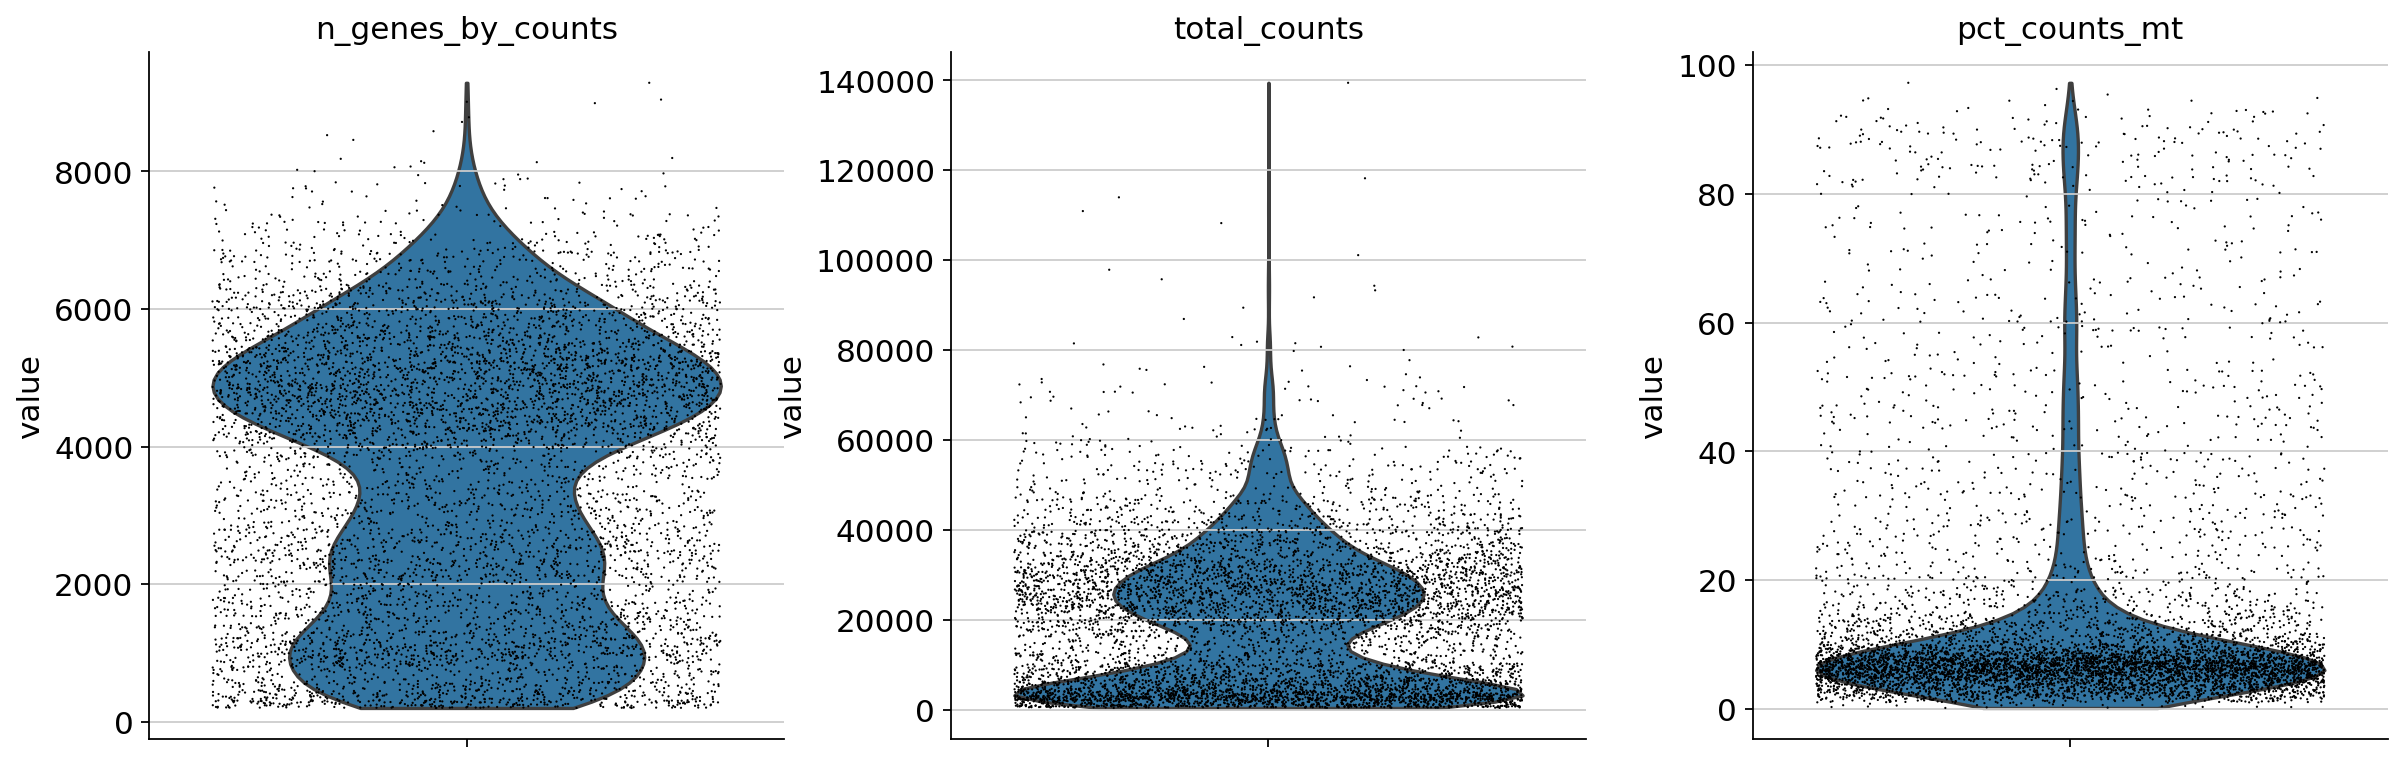

In [8]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

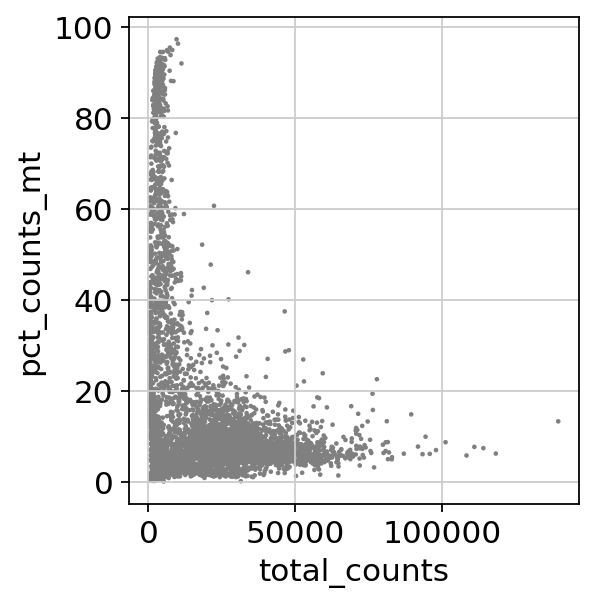

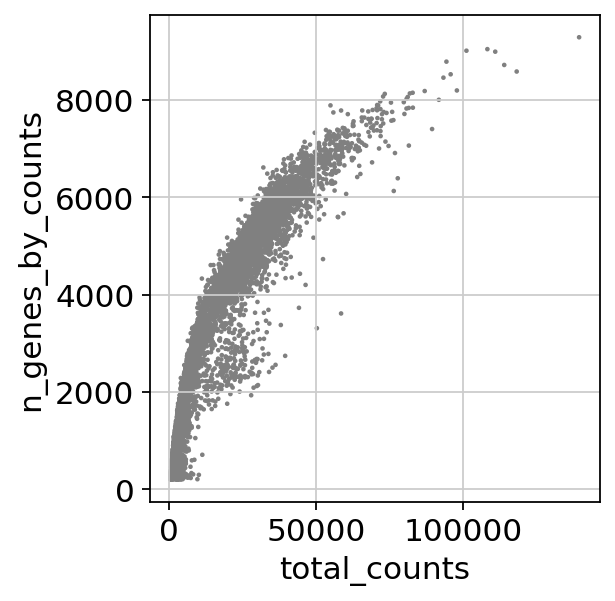

In [9]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [10]:
#filter cells
adata = adata[adata.obs.n_genes_by_counts > 1000, :]
adata = adata[adata.obs.pct_counts_mt < 15, :]

In [11]:
#remove mt and ribo genes
rbmt_gene_list = pd.read_csv ("genelist.mm.txt", sep = '\t',header=None)
rbmt_genes = rbmt_gene_list[1][rbmt_gene_list[0].isin(["RB","chrM"])]

In [12]:
excluded_genes = np.logical_not(adata.var["gene_ids"].isin(rbmt_genes))
adata_rbmtRM = adata[:,excluded_genes].copy()

In [13]:
sc.external.pp.scrublet(adata_rbmtRM,sim_doublet_ratio=20)
adata.obs['predicted_doublet'] = adata_rbmtRM.obs['predicted_doublet'].astype(int)
adata.obs['doublet_score'] = adata_rbmtRM.obs['doublet_score']

Running Scrublet
filtered out 239 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)


/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.45
Detected doublet rate = 0.5%
Estimated detectable doublet fraction = 15.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.0%
    Scrublet finished (0:02:41)


Trying to set attribute `.obs` of view, copying.


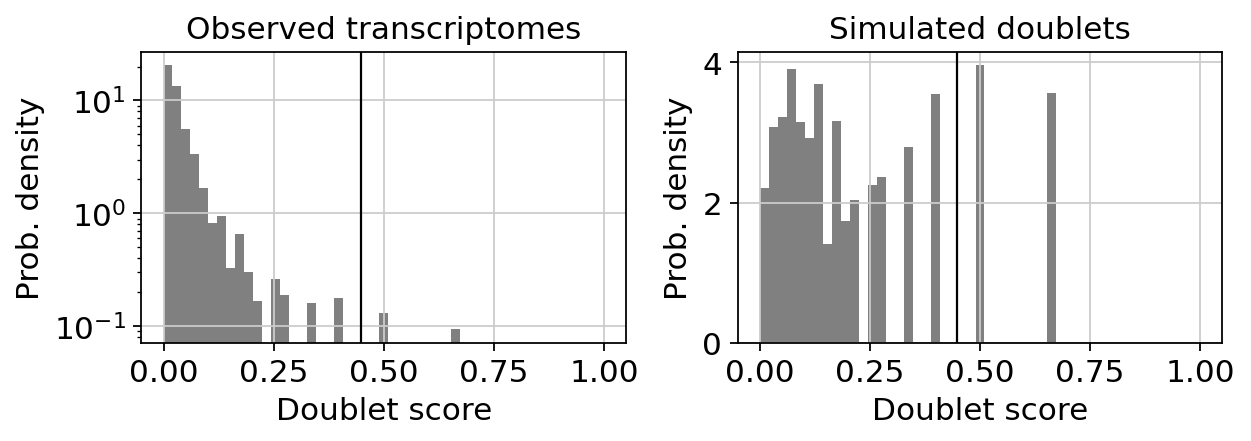

In [14]:
sc.external.pl.scrublet_score_distribution(adata_rbmtRM)

In [15]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
adata.raw = adata

normalizing counts per cell
    finished (0:00:00)


In [17]:
#remove mt and ribo genes
rbmt_gene_list = pd.read_csv ("genelist.mm.txt", sep = '\t',header=None)
rbmt_genes = rbmt_gene_list[1][rbmt_gene_list[0].isin(["RB","chrM"])]

In [18]:
excluded_genes = np.logical_not(adata.var["gene_ids"].isin(rbmt_genes))
adata = adata[:,excluded_genes].copy()
adata_dbRM = adata[adata.obs['predicted_doublet']==0,:].copy()

In [20]:
adata_dbRM

AnnData object with n_obs × n_vars = 5193 × 19706
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'predicted_doublet', 'doublet_score'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'test_elbo', 'test_epoch', 'log1p'
    layers: 'counts'

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:02)


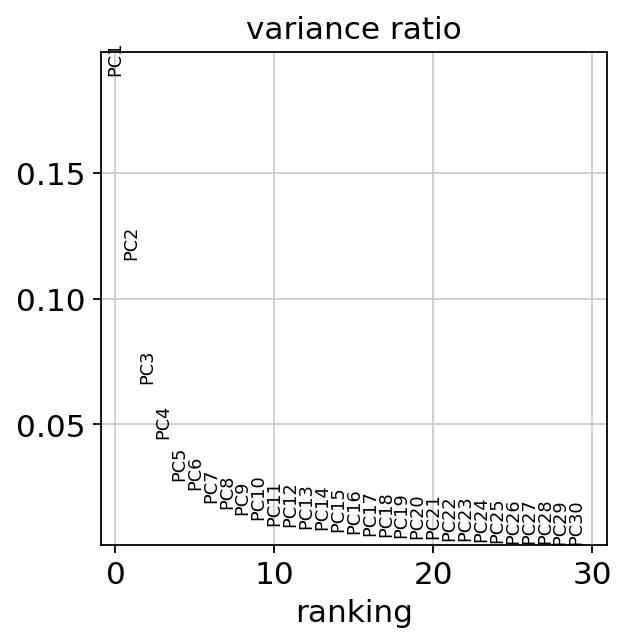

In [21]:
sc.pp.highly_variable_genes(
    adata_dbRM,
    n_top_genes = 5000,
    layer="counts",
    flavor="seurat_v3",
    span = 1
)

sc.tl.pca(adata_dbRM, svd_solver='arpack',n_comps=30)
sc.pl.pca_variance_ratio(adata_dbRM)

In [22]:
np.sum(adata_dbRM.uns["pca"]['variance_ratio'])

0.6314368

In [24]:
communities, graph, Q = phenograph.cluster(adata_dbRM.obsm['X_pca'],k=15,clustering_algo='leiden',seed=0)
print(np.unique(communities,return_counts=True))
adata_dbRM.obs['Phenograph_cluster_k15_dbRM'] = [str(x) for x in communities]
adata_dbRM.obs['Phenograph_cluster_k15_dbRM'] = adata_dbRM.obs['Phenograph_cluster_k15_dbRM'].astype("category")
sc.pp.neighbors(adata_dbRM, n_neighbors=30)
sc.tl.umap(adata_dbRM)

Finding 15 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 3.6001648902893066 seconds
Jaccard graph constructed in 8.38330626487732 seconds
Running Leiden optimization
Leiden completed in 0.17963838577270508 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 19.96142864227295 seconds
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34]), array([385, 345, 314, 271, 264, 251, 239, 223, 221, 213, 190, 185, 176,
       173, 173, 137, 128, 120, 117, 115, 114, 102,  89,  81,  78,  78,
        70,  68,  62,  59,  32,  31,  30,  30,  29]))
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinate

In [29]:
sig_gene_final = {'cell cycle':['Top2a','Mki67'],
                 'stem':['Ascl2','Lgr5','Smoc2'], 
                  'crypt_top_colonocyte':['Car4','Aqp8','Ceacam1','Lypd8'],
                'enterocyte':['Alpi','Slc26a2','Prss32','Car1'],
                 'goblet':['Muc2','Ccl9','Tff3','Agr2'],
                  'TA/progenitor':['Stmn1','Tubb5','Prom1'],
                  'tuft':['Dclk1','Lrmp','Trpm5','Gfi1b','Cd24a'], 
                  'EE':['Chga','Cpe','Chgb','Gfra3'],
                  'endo':['Pecam1','Emcn','Cdh5','Flt4'],
                  'lymphatic':['Lyve1','Prox1','Ccl21a'],
                  'glial':['S100b','Gfap','Plp1'],
                  'pericyte':['Rgs5','Ndufa4l2','Des','Cox4i2'],
                  'myofibroblasts':['Acta2','Myh11','Vim'],
                  'stromal':['Col6a2','Col1a2','Vim','Pdgfra','Cd44','Dpt','Cd34'],
                  'pDC':['Irf8','Bst2','Runx2','Tcf4','Siglech'],
                  'macrophage':['Lyz1','Csf1r','Lyz2','Apoe','C1qa'],
                  'cDC/monocyte':['Flt3','Nr4a1','Batf3','Ccr2','Atox1','Ifi30'],
                  'plasma':['Igha','Igkc','Mzb1','Ccr10','Xbp1'],
                  'T cell':['Cd3g','Cd4','Cd8a'],
                  'resting B cell':['Ighd','Ebf1','Ighm'],
                  'cycling/GC B_cell':['Aicda','Hmgb2','Mbd4']
}

    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_Phenograph_cluster_k15_dbRM']`
categories: 0, 1, 10, etc.
var_group_labels: cell cycle, stem, crypt_top_colonocyte, etc.


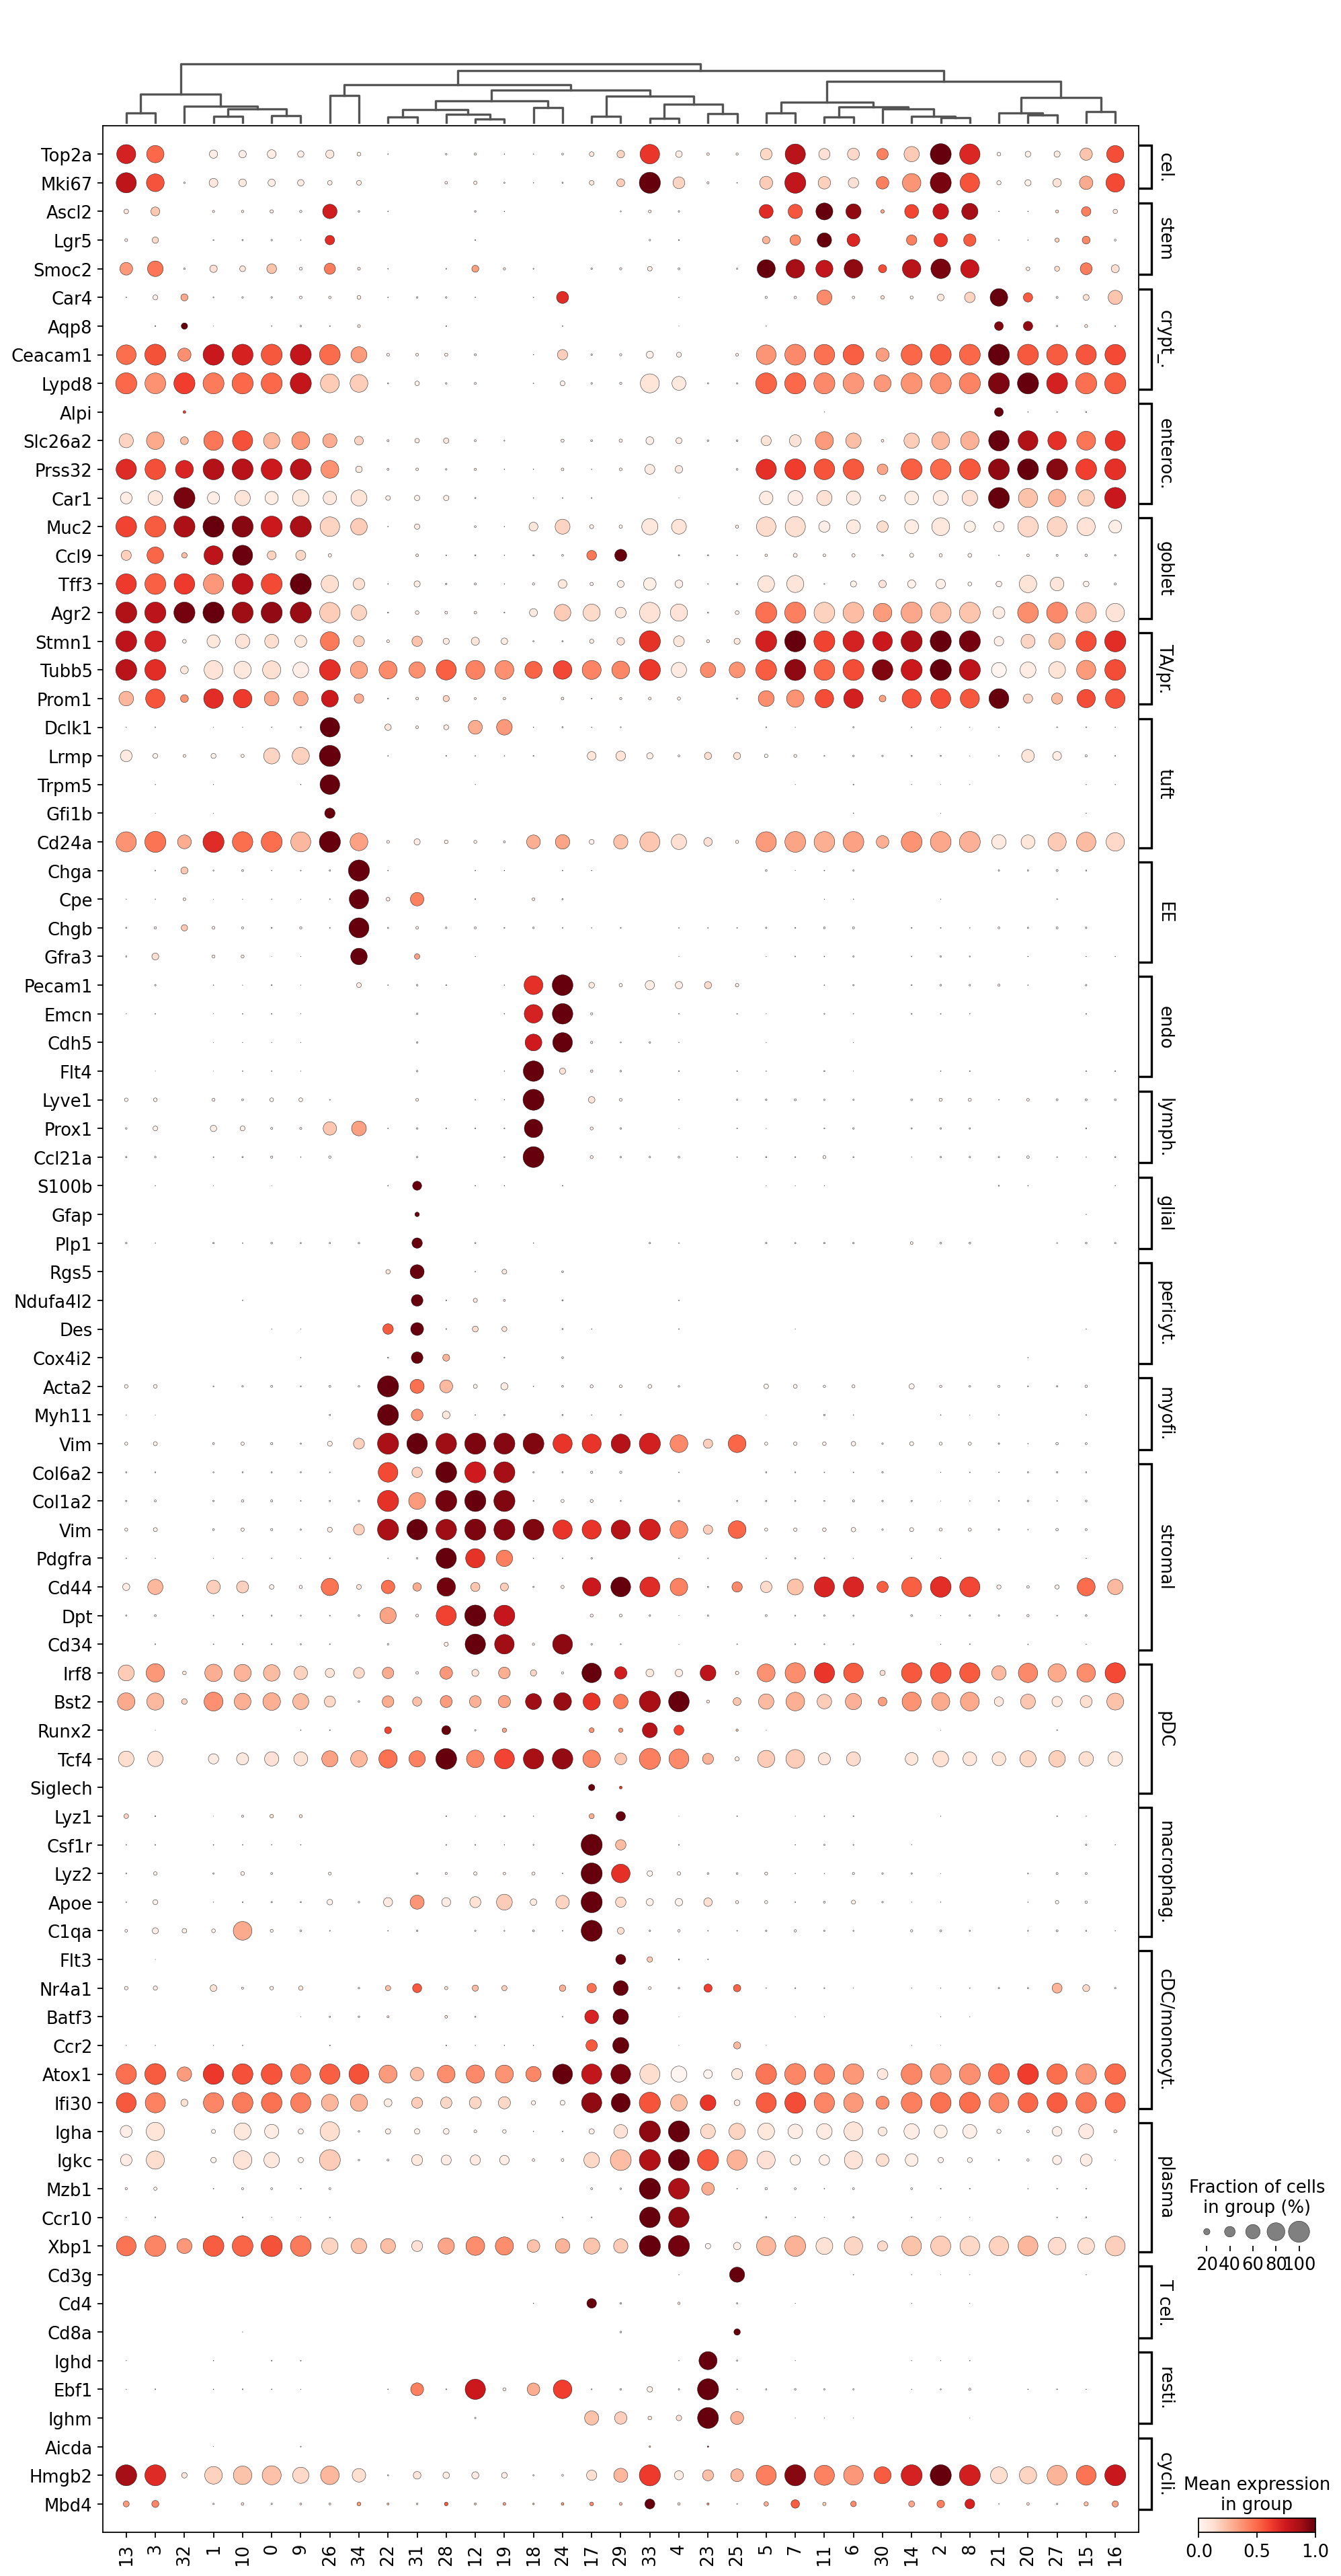

In [26]:
sc.tl.dendrogram(adata_dbRM,groupby='Phenograph_cluster_k15_dbRM')
sc.pl.dotplot(adata_dbRM,sig_gene_final,groupby='Phenograph_cluster_k15_dbRM',dendrogram=1,swap_axes=True,var_group_rotation=0, standard_scale='var')

In [27]:
coarse_annotation_dbRM = {
    '25':'T cell',
    '33':'cycling/GC B cell','4':'plasma','23':'B cell',
    '29': 'monocyte/granulocyte','17':'activated_macrophage', 
    '34':'enterendocrine',
    '26':'tuft',
    '18':'lymphatic',
    '24':'blood vasc.',
    '31':'glial_pericyte',
    '22':'myofibroblast',
    '28':'str','19':'str','12':'str',
    
    '20':'enterocyte','21':'enterocyte','27':'enterocyte',
    '5':'Lgr5+stem','7':'Lgr5+stem','15':'Lgr5+stem','16':'Lgr5+stem','2':'Lgr5+stem','8':'Lgr5+stem','11':'Lgr5+stem','30':'Lgr5+stem','14':'Lgr5+stem','6':'Lgr5+stem',
    '0':'goblet','3':'goblet','13':'goblet','1':'goblet','9':'goblet','10':'goblet',
    '32':'enterocyte_goblet'
}

coarse_cluster_dbRM = [coarse_annotation_dbRM[x] for x in adata_dbRM.obs['Phenograph_cluster_k15_dbRM']]
adata_dbRM.obs['coarse_cluster_dbRM'] = coarse_cluster_dbRM

/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'coarse_cluster_dbRM' as categorical


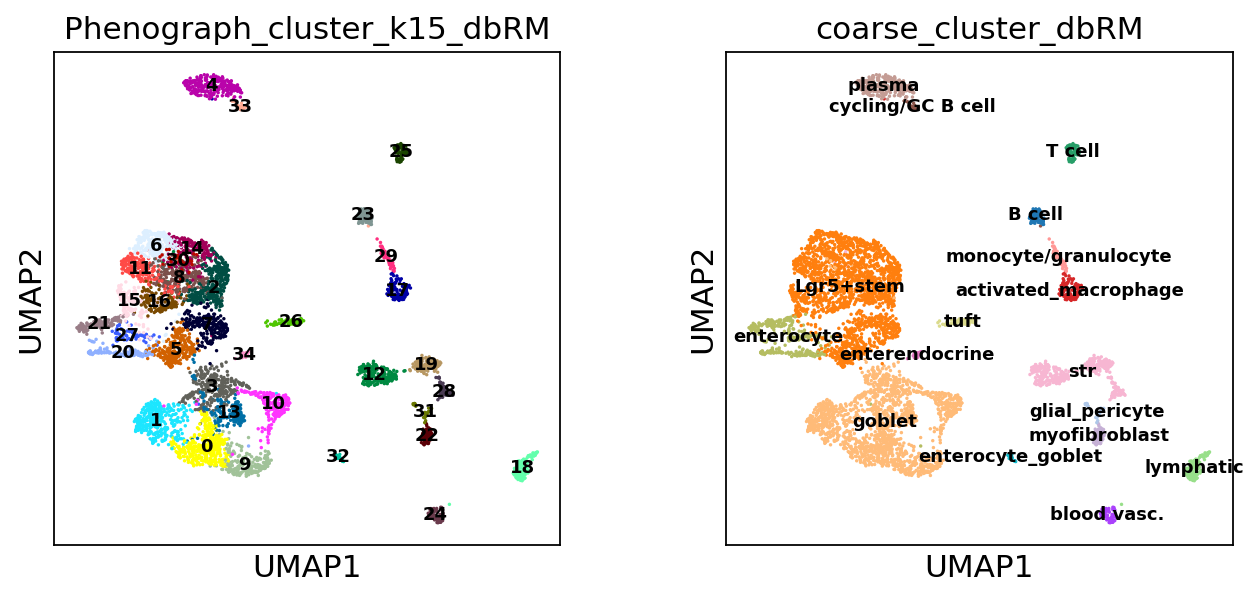

In [28]:
sc.pl.umap(adata_dbRM, color=['Phenograph_cluster_k15_dbRM','coarse_cluster_dbRM'],legend_loc='on data',size=50000/adata.obs.shape[0],legend_fontsize="xx-small")

In [30]:
adata_epi = adata_dbRM[adata_dbRM.obs['coarse_cluster_dbRM'].isin(np.array(['Lgr5+stem','enterocyte'])),:].copy()

In [31]:
adata_epi

AnnData object with n_obs × n_vars = 2187 × 19706
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'predicted_doublet', 'doublet_score', 'Phenograph_cluster_k30_dbRM', 'Phenograph_cluster_k15_dbRM', 'coarse_cluster_dbRM'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'test_elbo', 'test_epoch', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'dendrogram_Phenograph_cluster_k15_dbRM', 'Phenograph_cluster_k15_dbRM_colors', 'coarse_cluster_dbRM_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/scanpy/plotting/_preprocessing.py:81: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  pl.xlim(0.95 * np.min(means), 1.05 * np.max(means))


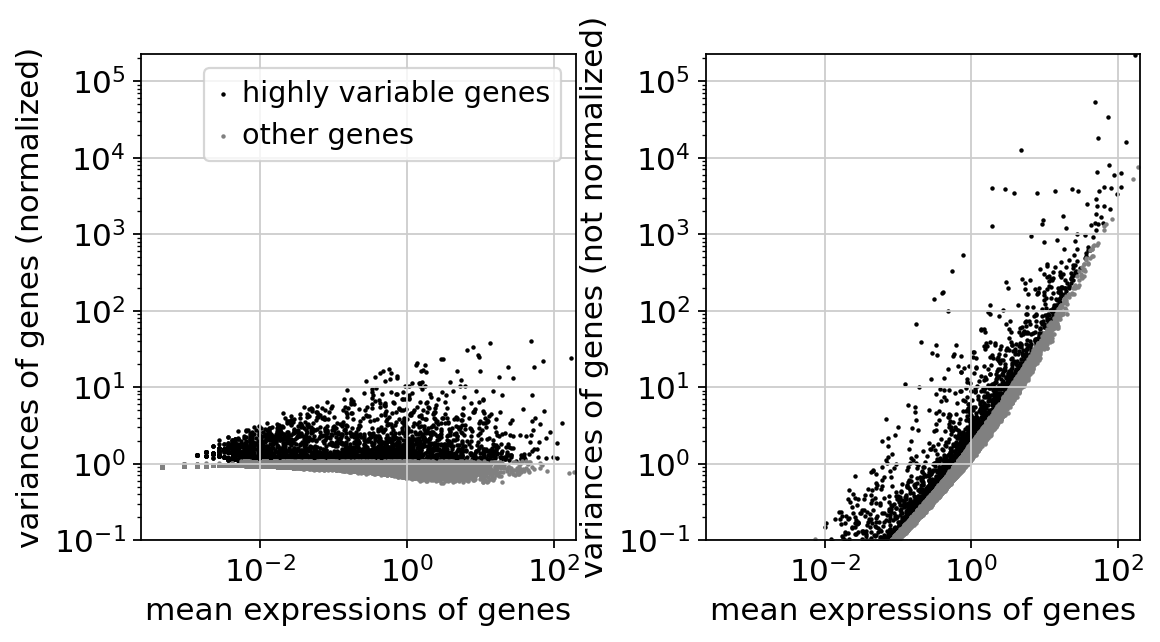

computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:01)


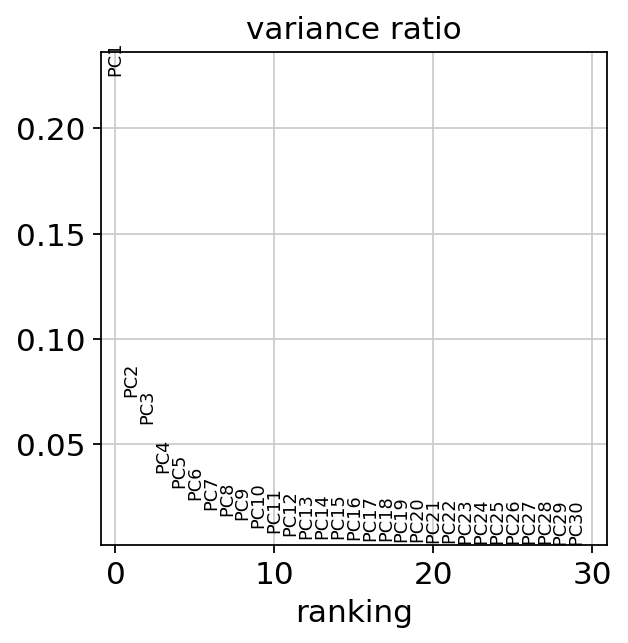

In [32]:
sc.pp.highly_variable_genes(
    adata_epi,
    n_top_genes = 3000,
    layer="counts",
    flavor="seurat_v3",
    span = 1
)
sc.pl.highly_variable_genes(adata_epi,log=True)
sc.tl.pca(adata_epi, svd_solver='arpack',n_comps=30)
sc.pl.pca_variance_ratio(adata_epi,n_pcs=30)

In [33]:
communities, graph, Q = phenograph.cluster(adata_epi.obsm['X_pca'],k=30,clustering_algo='leiden',seed=0)
print(np.unique(communities,return_counts=True))
adata_epi.obs['Phenograph_cluster_epi_k30'] = [str(x) for x in communities]
adata_epi.obs['Phenograph_cluster_epi_k30'] = adata_epi.obs['Phenograph_cluster_epi_k30'].astype("category")

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.232400894165039 seconds
Jaccard graph constructed in 7.512293577194214 seconds
Running Leiden optimization
Leiden completed in 0.06878876686096191 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 16.882028579711914 seconds
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), array([293, 253, 206, 172, 170, 168, 147, 134, 125, 110, 102,  86,  78,
        72,  49,  22]))


In [34]:
sig_gene_epi = {'cell cycle':['Top2a','Mki67'],
                 'stem':['Ascl2','Lgr5','Smoc2'], 
                  'crypt_top_colonocyte':['Car4','Aqp8','Ceacam1','Lypd8'],
                'enterocyte':['Alpi','Slc26a2','Prss32','Car1'],
                  'TA/progenitor':['Stmn1','Tubb5','Prom1']
}

    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_Phenograph_cluster_epi_k30']`
categories: 0, 1, 10, etc.
var_group_labels: cell cycle, stem, crypt_top_colonocyte, etc.


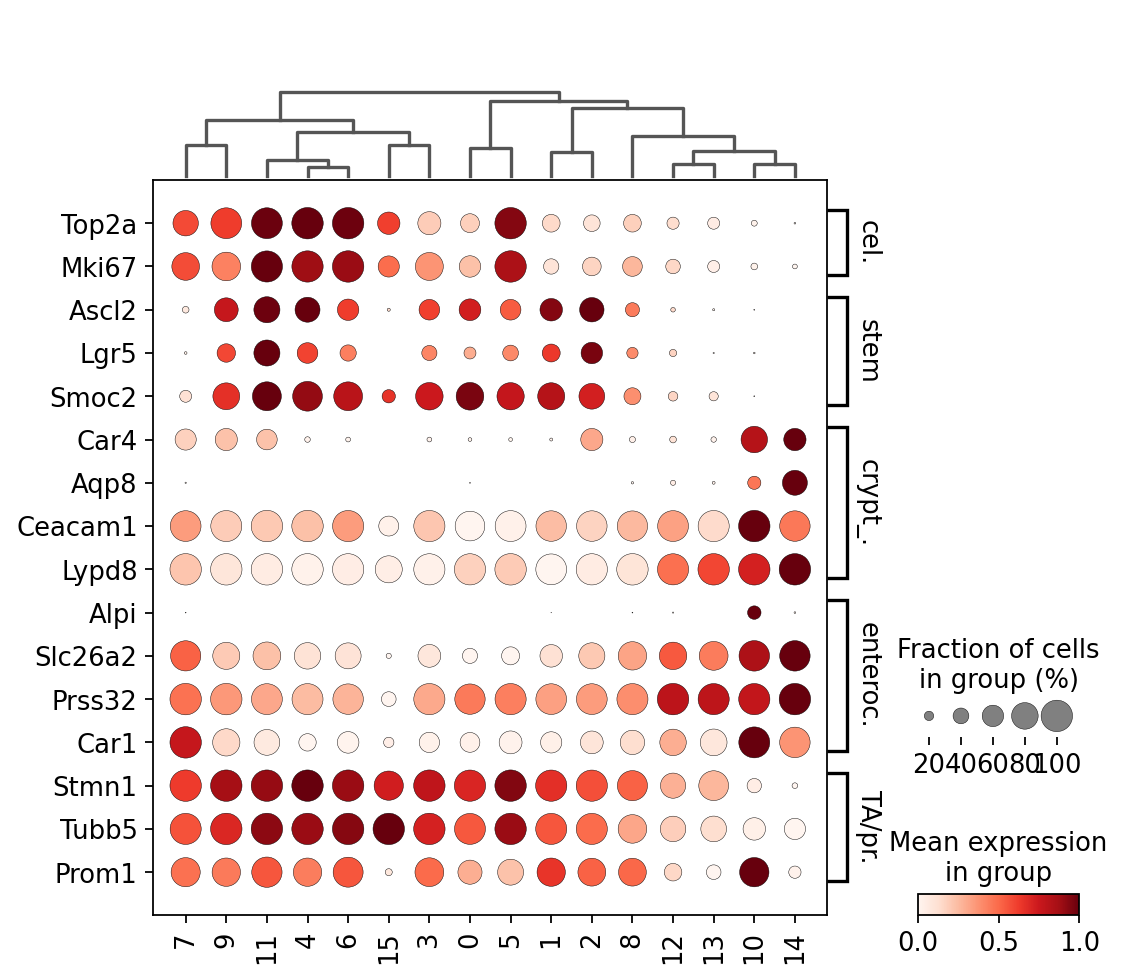

In [36]:
sc.tl.dendrogram(adata_epi,groupby='Phenograph_cluster_epi_k30')
sc.pl.dotplot(adata_epi,sig_gene_epi,groupby='Phenograph_cluster_epi_k30',dendrogram=1,swap_axes=True,var_group_rotation=0, standard_scale='var')

In [37]:
epi_annotation={
    '5':'Lgr5+_stem_cycling','6':'Lgr5+_stem_cycling','4':'Lgr5+_stem_cycling','11':'Lgr5+_stem_cycling','7':'Lgr5+_stem_cycling','9':'Lgr5+_stem_cycling',
    '1':'Lgr5+_stem','2':'Lgr5+_stem','0':'Lgr5+_stem','15':'Lgr5+_stem','3':'Lgr5+_stem',
    '14':'mature_enterocyte_1','10':'mature_enterocyte_2',
    '13':'enterocyte_1','12':'enterocyte_2','8':'TA',
}

epi_cluster = [epi_annotation[x] for x in adata_epi.obs['Phenograph_cluster_epi_k30']]
adata_epi.obs['epi_cluster'] = epi_cluster


In [64]:
#transfer labels from adata_epi, adata_gob, and adata_str to adata_dbRM  

adata_epi.obs['epi_cluster_finer'] = adata_epi.obs['epi_cluster'].astype(str)    

for idx in adata_epi.obs.index:
    adata_epi.obs['epi_cluster_finer'][idx] = adata_dbRM.obs['cell_state_finer'][idx]

/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [38]:
#subcluster goblets:
adata_gob = adata_dbRM[adata_dbRM.obs['coarse_cluster_dbRM']=="goblet",:].copy()
adata_gob

AnnData object with n_obs × n_vars = 1577 × 19706
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'predicted_doublet', 'doublet_score', 'Phenograph_cluster_k30_dbRM', 'Phenograph_cluster_k15_dbRM', 'coarse_cluster_dbRM'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'test_elbo', 'test_epoch', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'dendrogram_Phenograph_cluster_k15_dbRM', 'Phenograph_cluster_k15_dbRM_colors', 'coarse_cluster_dbRM_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/scanpy/plotting/_preprocessing.py:81: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  pl.xlim(0.95 * np.min(means), 1.05 * np.max(means))


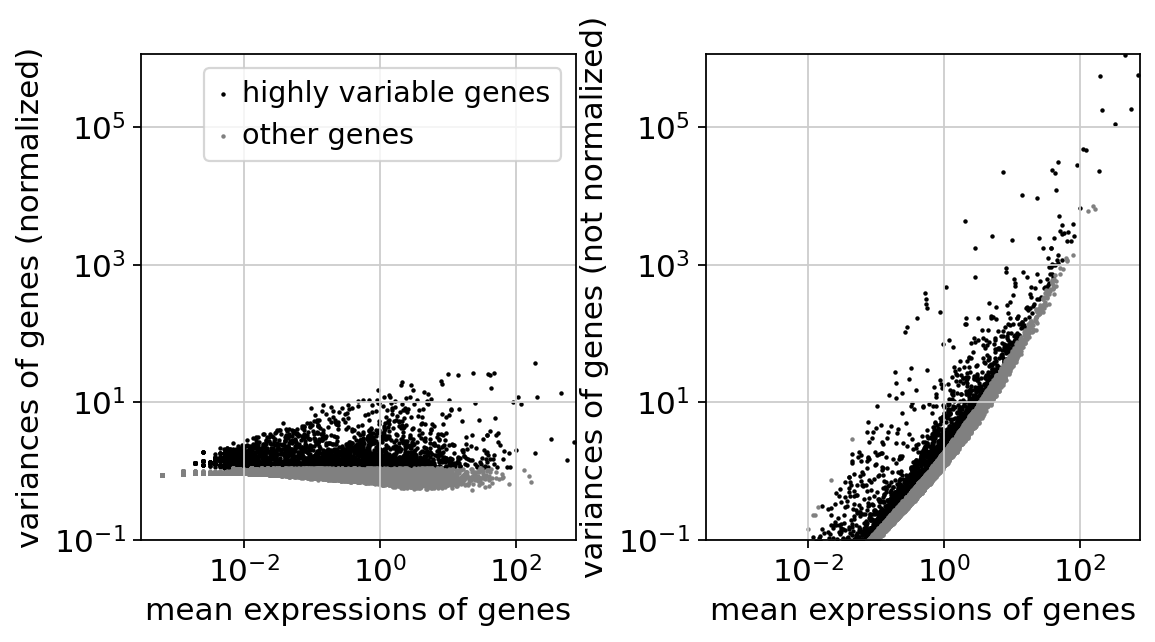

computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)


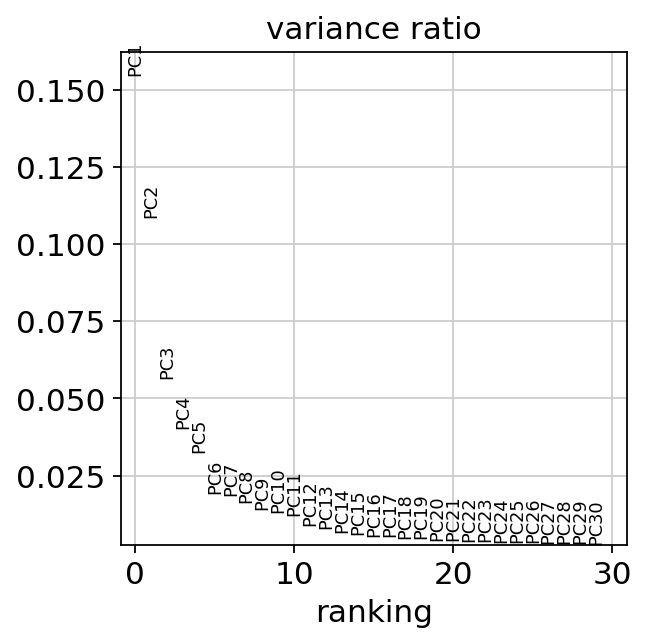

In [39]:
sc.pp.highly_variable_genes(
    adata_gob,
    n_top_genes = 3000,
    layer="counts",
    flavor="seurat_v3",
    span = 1
)
sc.pl.highly_variable_genes(adata_gob,log=True)
sc.tl.pca(adata_gob, svd_solver='arpack',n_comps=30)
sc.pl.pca_variance_ratio(adata_gob,n_pcs=30)

In [40]:
communities, graph, Q = phenograph.cluster(adata_gob.obsm['X_pca'],k=30,clustering_algo='leiden',seed=0)
print(np.unique(communities,return_counts=True))
adata_gob.obs['Phenograph_cluster_gob_k30'] = [str(x) for x in communities]
adata_gob.obs['Phenograph_cluster_gob_k30'] = adata_gob.obs['Phenograph_cluster_gob_k30'].astype("category")

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.7835593223571777 seconds
Jaccard graph constructed in 7.521436929702759 seconds
Running Leiden optimization
Leiden completed in 0.04938864707946777 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 16.751765727996826 seconds
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([283, 230, 214, 194, 168, 164, 154,  88,  66,  16]))


In [41]:
sig_gene_gob = {'cell cycle':['Top2a','Mki67'],
                 'goblet':['Muc2','Ccl9','Tff3','Agr2']
}

    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_Phenograph_cluster_gob_k30']`
categories: 0, 1, 2, etc.
var_group_labels: cell cycle, goblet


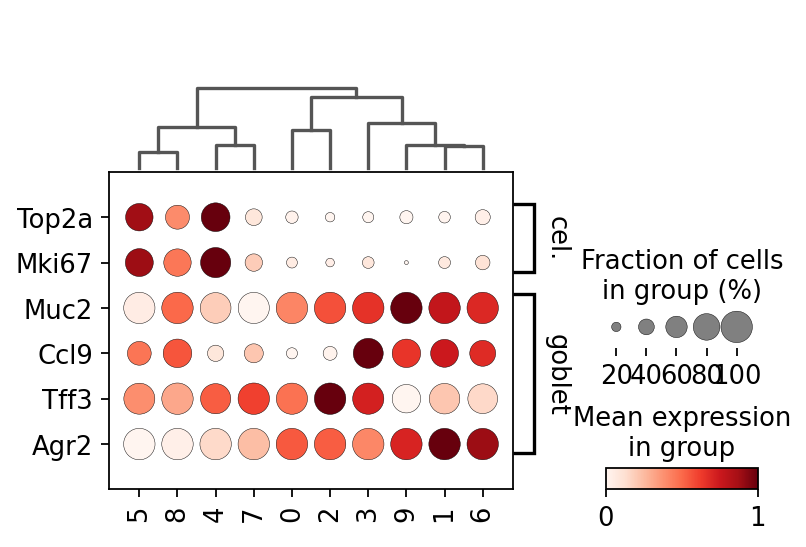

In [42]:
sc.tl.dendrogram(adata_gob,groupby='Phenograph_cluster_gob_k30')
sc.pl.dotplot(adata_gob,sig_gene_gob,groupby='Phenograph_cluster_gob_k30',dendrogram=1,swap_axes=True,var_group_rotation=0, standard_scale='var')

In [74]:
gob_annotation={
    '5':'goblet_cycling','8':'goblet_cycling','4':'goblet_cycling','7':'goblet_cycling',
    '0':'goblet_1','1':'goblet_2_8','9':'goblet_2_8','2':'goblet_3','3':'goblet_4','6':'goblet_5',
}

gob_cluster = [gob_annotation[x] for x in adata_gob.obs['Phenograph_cluster_gob_k30']]
adata_gob.obs['gob_cluster'] = gob_cluster
adata_gob.obs['gob_cluster'] = adata_gob.obs['gob_cluster'].astype("category")

In [44]:
#reculster str cell
adata_str = adata_dbRM[adata_dbRM.obs['coarse_cluster_dbRM'].isin(np.array(['glial_pericyte','myofibroblast','str'])),:].copy()
adata_str

AnnData object with n_obs × n_vars = 473 × 19706
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'predicted_doublet', 'doublet_score', 'Phenograph_cluster_k30_dbRM', 'Phenograph_cluster_k15_dbRM', 'coarse_cluster_dbRM'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'test_elbo', 'test_epoch', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'dendrogram_Phenograph_cluster_k15_dbRM', 'Phenograph_cluster_k15_dbRM_colors', 'coarse_cluster_dbRM_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/scanpy/plotting/_preprocessing.py:81: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  pl.xlim(0.95 * np.min(means), 1.05 * np.max(means))


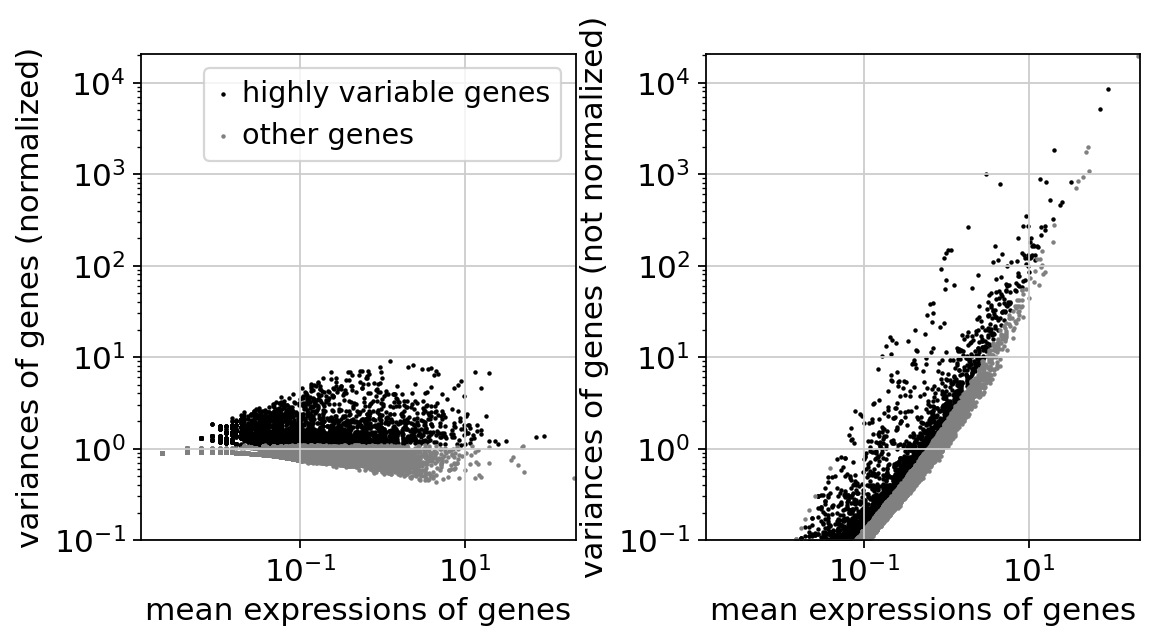

computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)


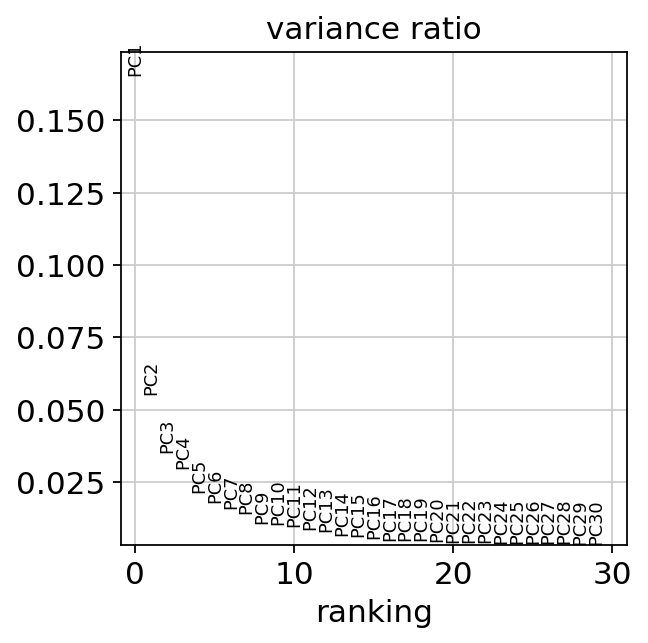

In [45]:
sc.pp.highly_variable_genes(
    adata_str,
    n_top_genes = 3000,
    layer="counts",
    flavor="seurat_v3",
    span = 1
)
sc.pl.highly_variable_genes(adata_str,log=True)
sc.tl.pca(adata_str, svd_solver='arpack',n_comps=30)
sc.pl.pca_variance_ratio(adata_str,n_pcs=30)

In [46]:
communities, graph, Q = phenograph.cluster(adata_str.obsm['X_pca'],k=30,clustering_algo='leiden',seed=0)
print(np.unique(communities,return_counts=True))
adata_str.obs['Phenograph_cluster_str_k30'] = [str(x) for x in communities]
adata_str.obs['Phenograph_cluster_str_k30'] = adata_str.obs['Phenograph_cluster_str_k30'].astype("category")

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.13273024559020996 seconds
Jaccard graph constructed in 7.914361476898193 seconds
Running Leiden optimization
Leiden completed in 0.010743856430053711 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 16.7670795917511 seconds
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([135,  91,  65,  63,  53,  37,  17,  12]))


    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_Phenograph_cluster_str_k30']`
categories: 0, 1, 2, etc.
var_group_labels: glial, pericyte, stromal, etc.


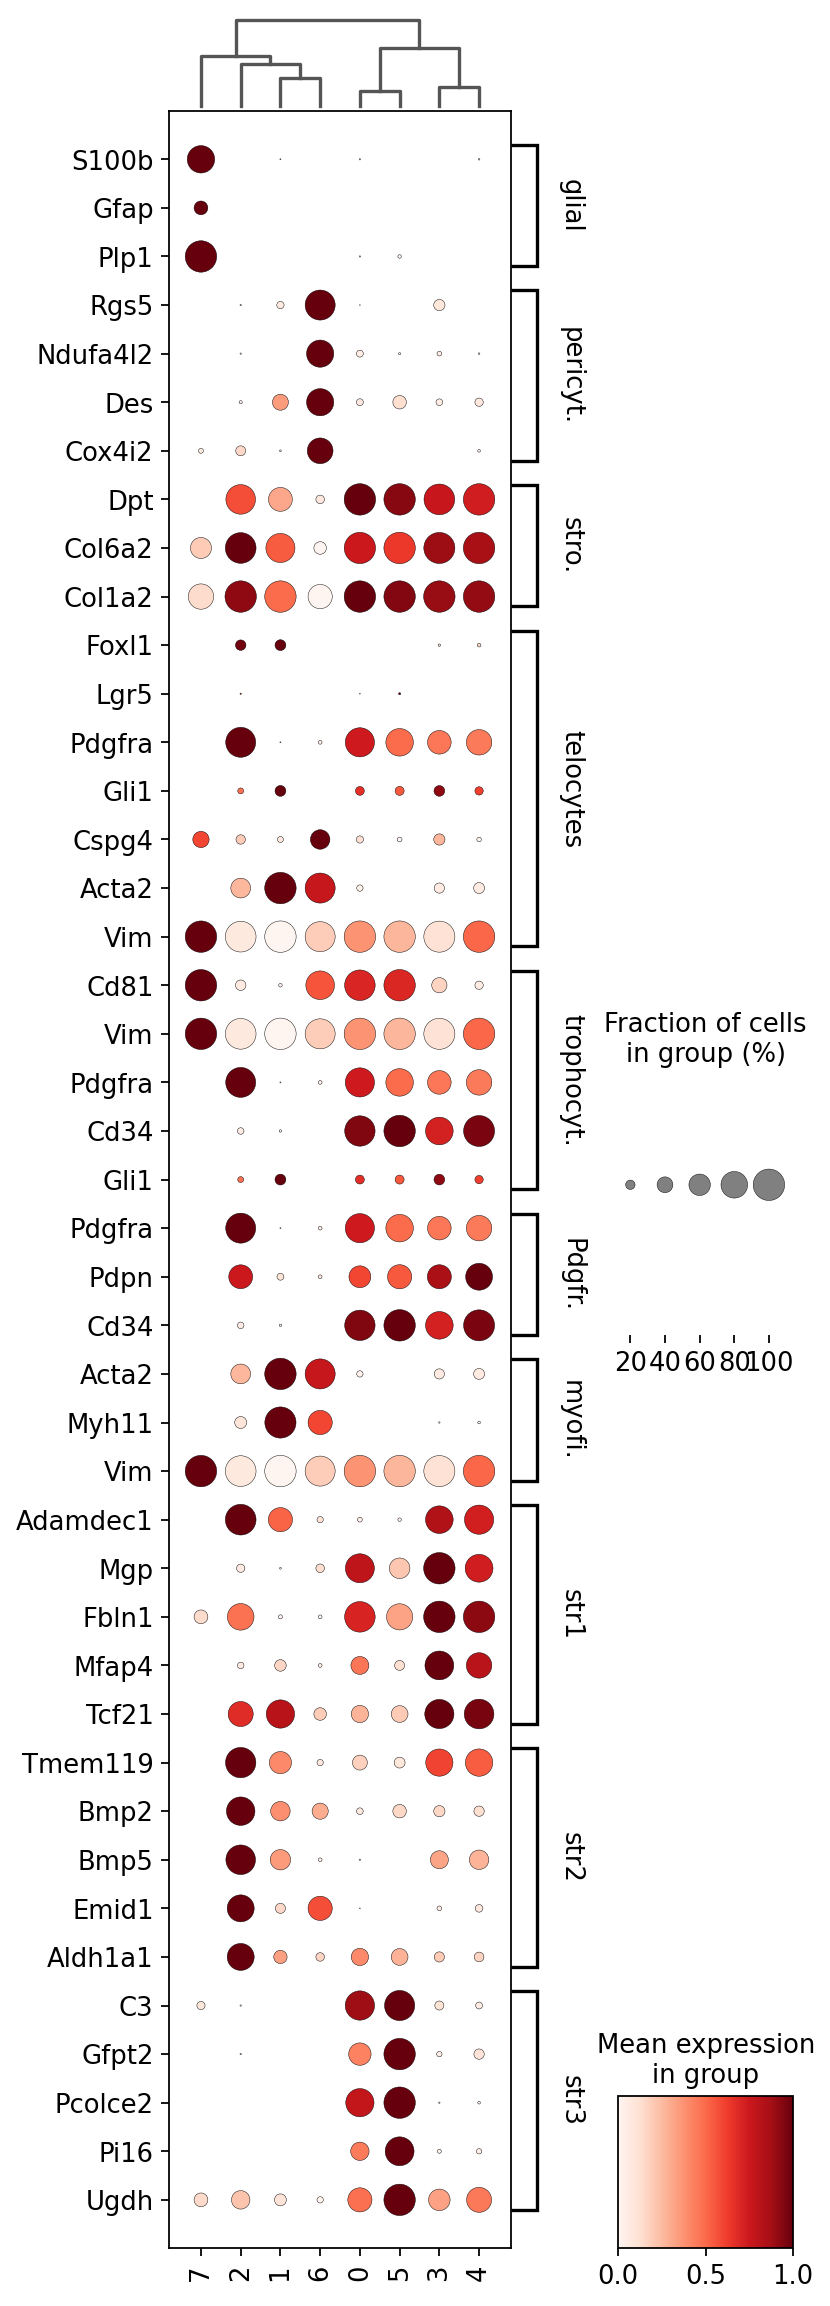

In [49]:
str_gene_list={ 'glial':['S100b','Gfap','Plp1'],
                  'pericyte':['Rgs5','Ndufa4l2','Des','Cox4i2'],
                'stromal':['Dpt','Col6a2','Col1a2'],
                'telocytes':['Foxl1','Lgr5','Pdgfra','Gli1','Cspg4','Acta2','Vim'],
                'trophocytes':['Cd81','Vim','Pdgfra','Cd34','Gli1'],
                'Pdgfra low pericryptal fibroblasts':['Pdgfra','Pdpn','Cd34'],
               'myofibroblasts':['Acta2','Myh11','Vim'],
               'str1':['Adamdec1','Mgp','Fbln1','Mfap4','Tcf21'],
               'str2':['Tmem119','Bmp2','Bmp5','Emid1','Aldh1a1'],
               'str3':['C3','Gfpt2','Pcolce2','Pi16','Ugdh']
              }
sc.tl.dendrogram(adata_str,groupby='Phenograph_cluster_str_k30')
sc.pl.dotplot(adata_str,str_gene_list,groupby='Phenograph_cluster_str_k30',dendrogram=1,swap_axes=True,var_group_rotation=0, standard_scale='var',figsize=(5,18))

In [50]:
str_annotation={
    '0':'str3','5':'str3',
    '2':'str2',
    '3':'str1','4':'str1',
    '1':'myofibroblast',
    '6':'pericytes',
    '7':'glial'
}

str_cluster = [str_annotation[x] for x in adata_str.obs['Phenograph_cluster_str_k30']]
adata_str.obs['str_cluster'] = str_cluster

In [75]:
#transfer labels from adata_epi, adata_gob, and adata_str to adata_dbRM  

adata_dbRM.obs['cell_state'] = adata_dbRM.obs['coarse_cluster_dbRM'].astype(str)    

for idx in adata_epi.obs.index:
    adata_dbRM.obs['cell_state'][idx] = adata_epi.obs['epi_cluster'][idx]
for idx in adata_gob.obs.index:
    adata_dbRM.obs['cell_state'][idx] = adata_gob.obs['gob_cluster'][idx]
for idx in adata_str.obs.index:
    adata_dbRM.obs['cell_state'][idx] = adata_str.obs['str_cluster'][idx]   

/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys

In [ ]:
#exclude an epithelial lineage cluster of low library size from downstream analysis

In [76]:
adata_sub = adata_dbRM[adata_dbRM.obs['coarse_cluster_dbRM'].isin(np.array(['goblet','Lgr5+stem','enterocyte_goblet','enterendocrine','tuft','enterocyte'])),:].copy()

/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_state' as categorical


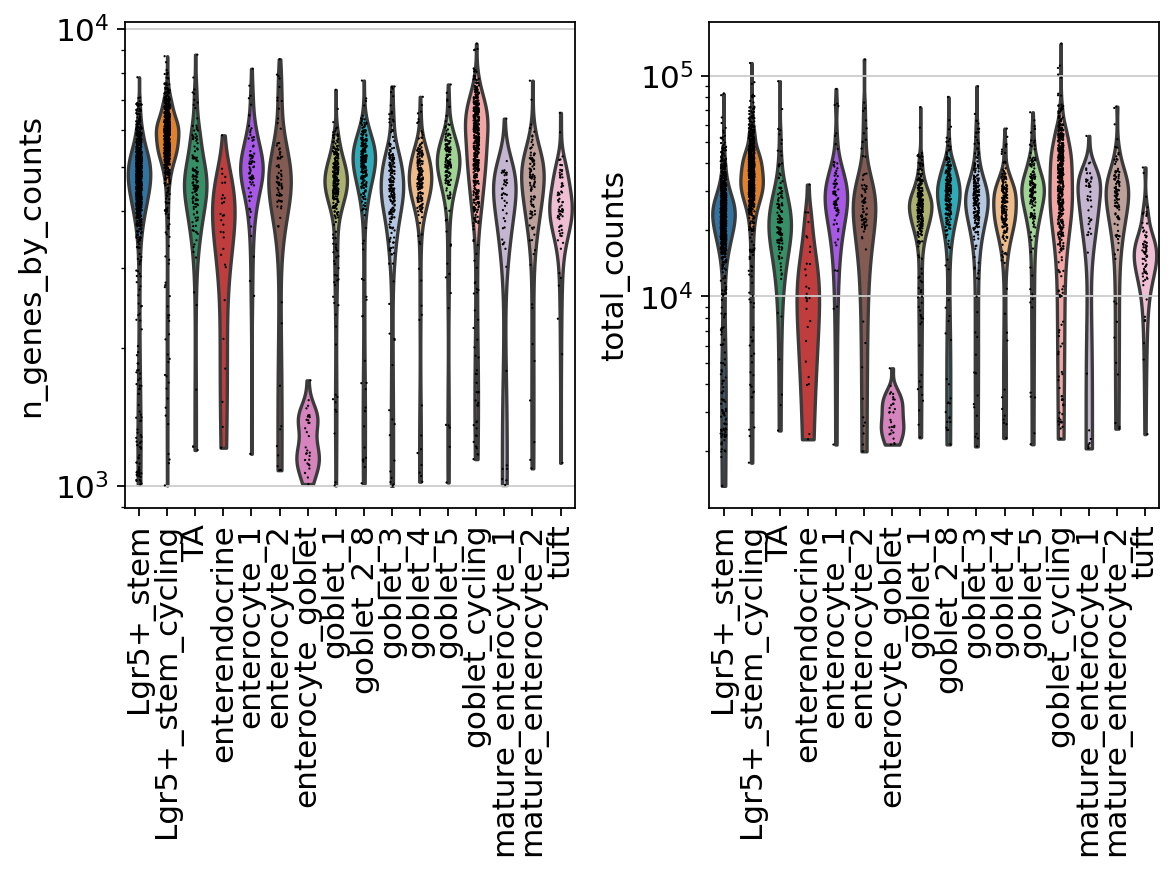

In [77]:
sc.pl.violin(adata_sub, groupby='cell_state',keys=['n_genes_by_counts','total_counts'],legend_fontsize="xx-small",rotation=90,log=True)

In [78]:
adata_dbRM_unknown_exc = adata_dbRM[adata_dbRM.obs['cell_state']!="enterocyte_goblet",:].copy()

/home/chut/miniconda3/envs/cellrank_R/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_state' as categorical


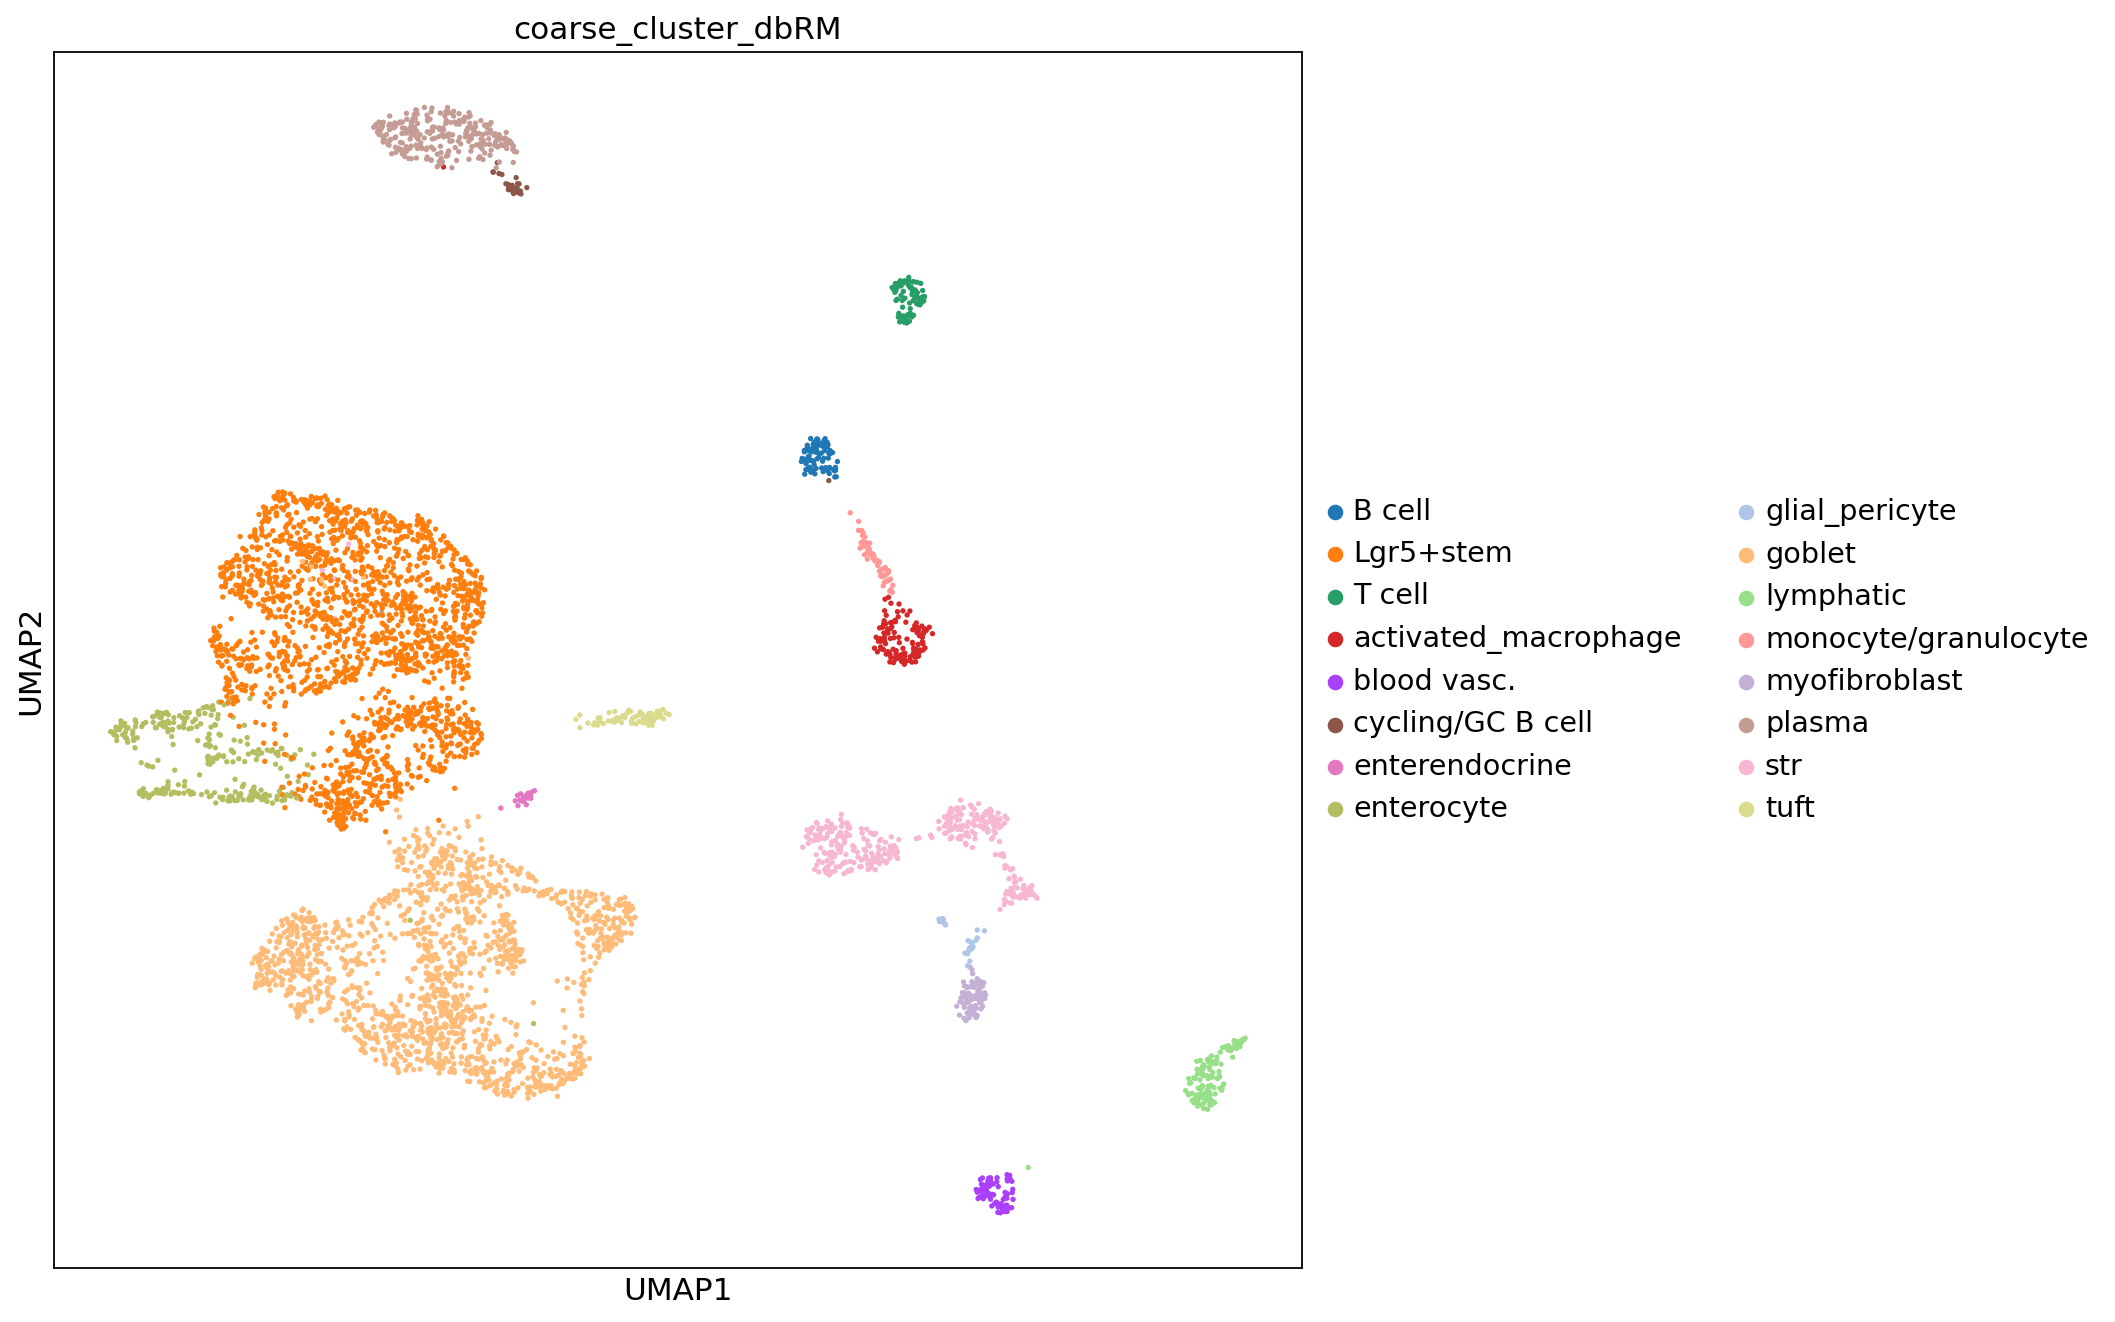

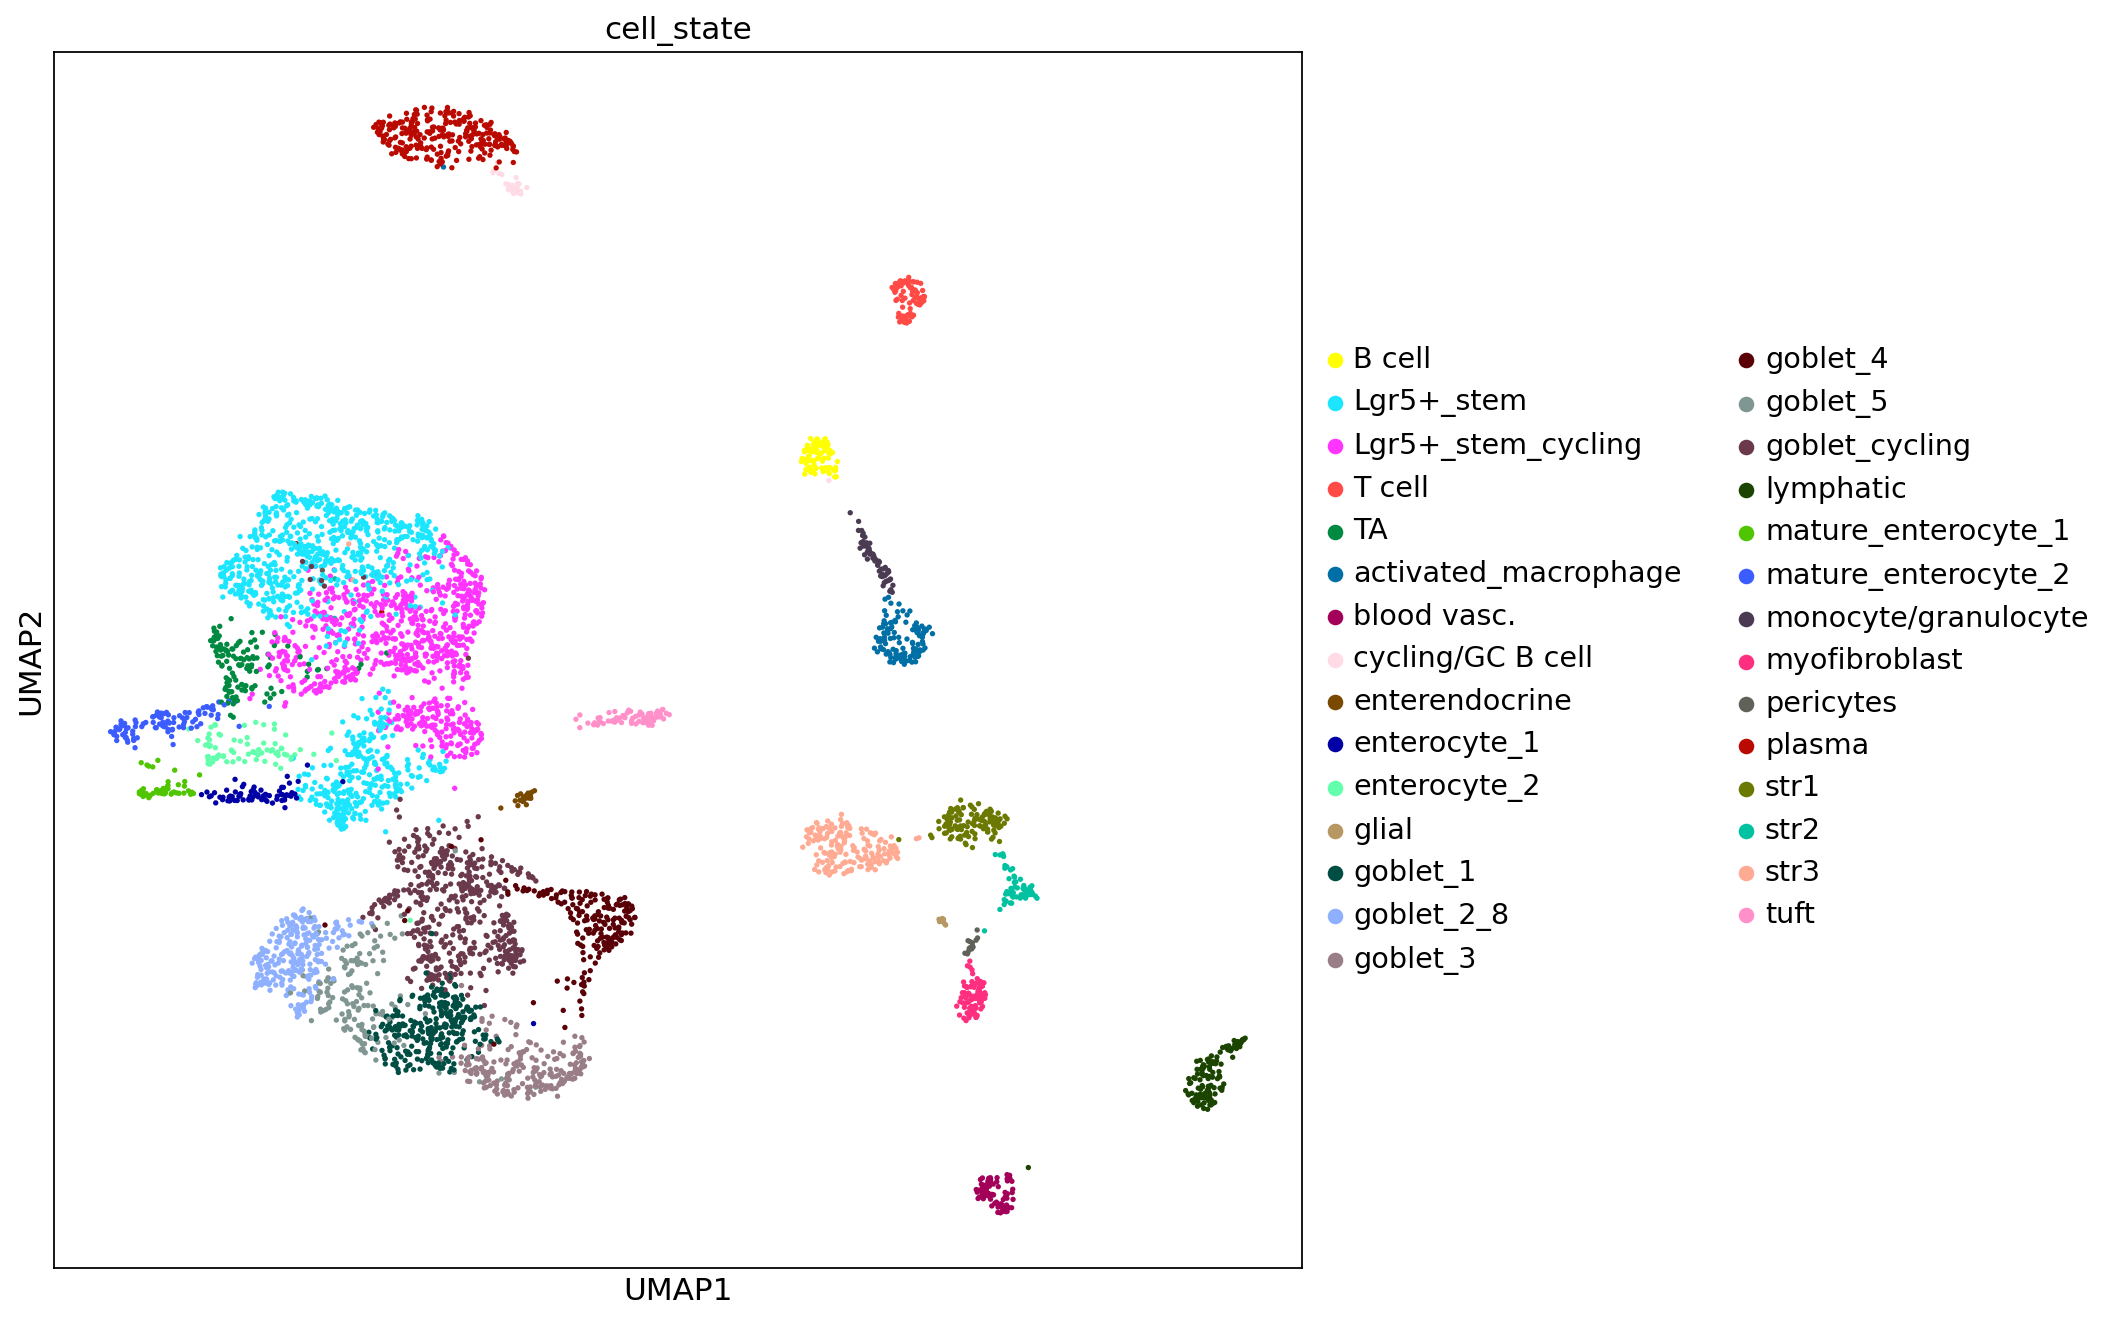

In [79]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata_dbRM_unknown_exc, color=['coarse_cluster_dbRM'])
    sc.pl.umap(adata_dbRM_unknown_exc, color=['cell_state'])

In [80]:
receptor_genes={'Reln':["Itgb1","Vldlr","Lrp8"],
               'Ccl21a':["Ccr7"],
               'Wnt2':["Fzd1","Fzd2","Fzd3","Fzd4","Fzd5","Fzd6","Fzd7","Fzd8","Fzd9","Fzd10","Lrp5","Lrp6"],
               "Ntn1":['Unc5a','Unc5b','Unc5c','Neo1'],
               'Rspo3':['Lgr4','Lgr5','Lgr6'],
               'Il33':['Il1rl1']}

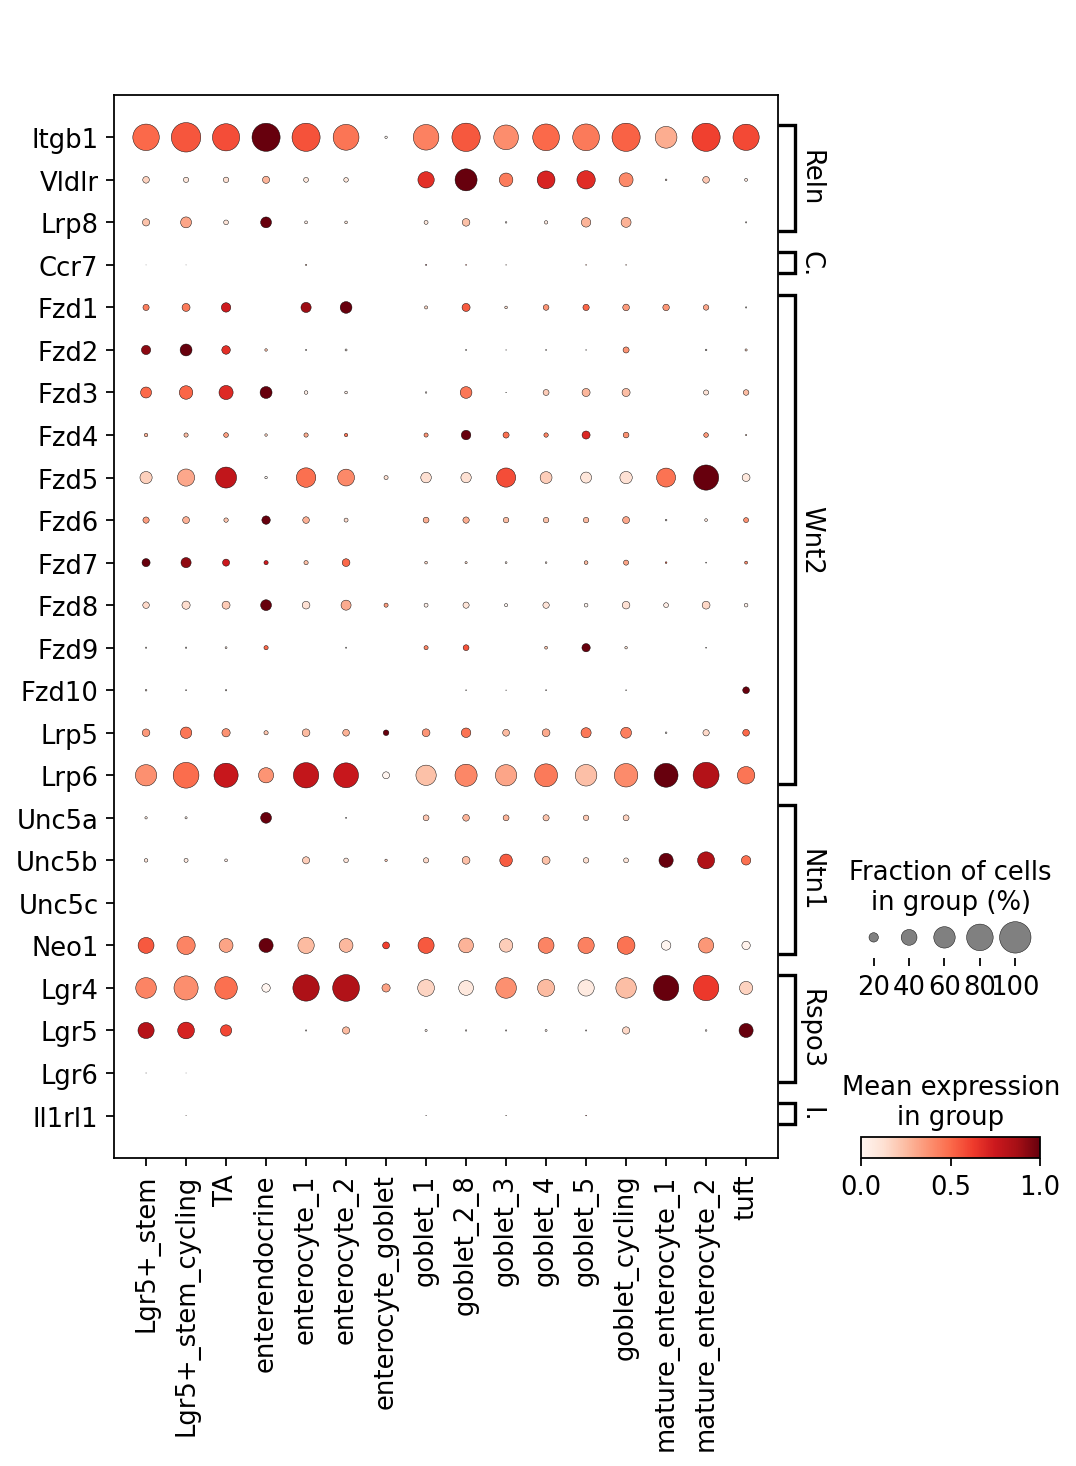

In [81]:
sc.pl.dotplot(adata_sub, var_names=receptor_genes, var_group_rotation=180,standard_scale='var',
                     groupby='cell_state',swap_axes=True)